In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import re  
import warnings
from pathlib import Path
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,8]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
sns.set()


In [2]:
from tqdm import tqdm
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

In [3]:
#import spacy
#import torchtext
#from textblob import TextBlob
#from torchtext.data import Field , TabularDataset , BucketIterator ,LabelField
#nlp = spacy.load(r'.\en_core_web_lg\en_core_web_lg-3.4.1')

In [4]:
# Note : I Checked The Data and Nulls Before Doing all these stuff 
%run dataset.ipynb import *

train , val , test , ids = getData()
train_loader = DataLoader(train , batch_size=512 , shuffle = True)
val_loader = DataLoader(val , batch_size=512 , shuffle = True)
test_loader = DataLoader(test , batch_size=512 )


In [5]:
%run models.ipynb import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'
basic_model = basic_NN(200 , 64).to(device)
optimizer = optim.SGD(basic_model.parameters() , lr = 1e-2 , weight_decay=3e-3)
criterion = nn.BCEWithLogitsLoss()


In [6]:
%run Training-Testing.ipynb import *
train_loss_list = []
val_loss_list = []
for epoch in range(33):
    tr_loss = training(basic_model , train_loader , criterion , optimizer , device)
    val_loss , true , preds = testing(basic_model , val_loader , criterion , device)
    train_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    
    if(epoch % 2 ==0 ):
        print(f'trainLoss={tr_loss} | valLoss={val_loss} | Roc = {roc_auc_score(true, preds)}')

trainLoss=0.4886074960231781 | valLoss=0.3691258728504181 | Roc = 0.7422528927733493
trainLoss=0.2806459069252014 | valLoss=0.2707180082798004 | Roc = 0.8150543337406683
trainLoss=0.25643599033355713 | valLoss=0.25440382957458496 | Roc = 0.8296747634459852
trainLoss=0.24929551780223846 | valLoss=0.24821774661540985 | Roc = 0.8354622522226196
trainLoss=0.24620074033737183 | valLoss=0.24437430500984192 | Roc = 0.8392039530865025
trainLoss=0.2443537563085556 | valLoss=0.24442021548748016 | Roc = 0.8415760648435293
trainLoss=0.24304607510566711 | valLoss=0.2449781447649002 | Roc = 0.8434042305848596
trainLoss=0.24166497588157654 | valLoss=0.2517189681529999 | Roc = 0.8453562516796583
trainLoss=0.2407589852809906 | valLoss=0.24336807429790497 | Roc = 0.847329539898424
trainLoss=0.23972511291503906 | valLoss=0.24492786824703217 | Roc = 0.8467364948634084
trainLoss=0.23866231739521027 | valLoss=0.24906282126903534 | Roc = 0.8492264169135866
trainLoss=0.2380996197462082 | valLoss=0.24361924827

### Not bad as a vanilla model , But Fortunately we can do better 

In [7]:
# Try To understand more about data 
df = pd.read_csv(r"C:\Users\besho\Downloads\Standard-Transaction\train.csv")
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [8]:
df.drop(['ID_code'] , axis = 1 ,inplace = True)
df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


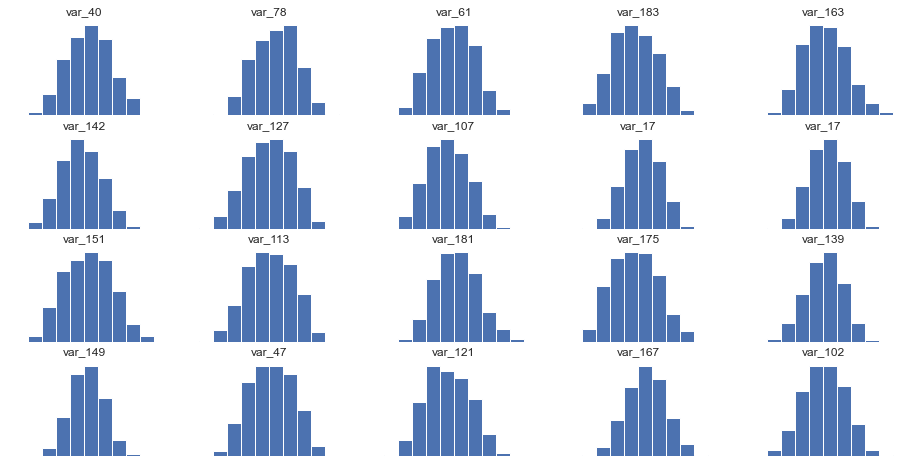

In [9]:
import random
choices = random.choices(df.columns[1:] , k = 20)
ind = 0

fig , ax = plt.subplots(nrows = 4 , ncols = 5)
for i in range(4):
    for j in range(5):     
        ax[i,j].hist(df[choices[ind]])
        ax[i,j].set_title(f"{choices[ind]}")
        ax[i,j].axis(False)
        ind +=1


is it make sense the whole features follows Normal Distribution ? Actually No <br>
I think the data are result of PCA

In [10]:
df.drop(['target'] , axis = 1).corr()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
var_0,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,0.006983,0.002429,0.004962,-0.002613,...,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,0.003258,0.001511,0.004098,-0.000832,...,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,0.000883,-0.000991,0.002648,-0.001932,...,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-0.000774,0.002500,0.003553,-0.000826,...,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
var_4,0.001326,0.000303,0.000723,-0.000322,1.000000,-0.001368,0.000049,0.004549,0.001194,-0.000918,...,0.001514,0.004357,0.003347,0.000813,-0.000068,0.003706,0.000513,-0.000046,-0.001821,-0.000786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.002073,-0.000785,-0.001070,0.001206,0.003706,-0.001274,0.001244,0.001854,0.001396,-0.000868,...,0.004571,0.000870,-0.004745,-0.003143,-0.001201,1.000000,0.002517,-0.004170,-0.000536,0.002042
var_196,0.004386,-0.000377,0.003952,-0.002800,0.000513,0.002880,0.005378,0.001045,-0.003242,0.000052,...,-0.000847,0.002466,-0.001386,-0.005308,-0.005040,0.002517,1.000000,-0.000454,0.000253,0.000607
var_197,-0.000753,-0.004157,0.001078,0.001164,-0.000046,-0.000535,-0.003565,0.003466,-0.004583,0.003701,...,-0.004974,0.000906,-0.000527,0.005068,0.000884,-0.004170,-0.000454,1.000000,0.001183,0.004991
var_198,-0.005776,-0.004861,-0.000877,-0.001651,-0.001821,-0.000953,-0.003025,0.000650,0.002950,0.002343,...,-0.000153,-0.000067,0.003451,0.001646,0.003194,-0.000536,0.000253,0.001183,1.000000,-0.004731


Ummm...more weird Results :) <br>
But Actually not weird at all , do u know why ? <br>
because our hypothesis that the data comes from PCA , and we know that PCA remove correlation . <br>
that makes our assumption strong enough to handle this now .

In [11]:
%run models.ipynb import *
improved_model = improved_NN(200 , 4,8,16).to(device)
optimizer = optim.Adam(improved_model.parameters() , lr = 5e-5 , weight_decay=1e-2)
criterion = nn.BCEWithLogitsLoss()

In [12]:
%run Training-Testing.ipynb import *
train_loss_list = []
val_loss_list = []
for epoch in range(33):
    tr_loss = training(improved_model , train_loader , criterion , optimizer , device)
    val_loss , true , preds = testing(improved_model , val_loader , criterion , device)
    train_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    
    if(epoch % 2 ==0 ):
        print(f'trainLoss={tr_loss} | valLoss={val_loss} | Roc = {roc_auc_score(true, preds)}')

trainLoss=0.5702835321426392 | valLoss=0.3925226628780365 | Roc = 0.8790288514864079
trainLoss=0.2588375210762024 | valLoss=0.2207866758108139 | Roc = 0.8936409384614226
trainLoss=0.23134732246398926 | valLoss=0.21310845017433167 | Roc = 0.8956606177313108
trainLoss=0.2255914956331253 | valLoss=0.21351014077663422 | Roc = 0.8970679405970248
trainLoss=0.22225114703178406 | valLoss=0.2094157189130783 | Roc = 0.8978371129776641
trainLoss=0.2196778655052185 | valLoss=0.2074815332889557 | Roc = 0.8984890494826482
trainLoss=0.21817557513713837 | valLoss=0.21098554134368896 | Roc = 0.8989570903292027
trainLoss=0.2165822982788086 | valLoss=0.2050485461950302 | Roc = 0.8987381688801115
trainLoss=0.2147856503725052 | valLoss=0.206368550658226 | Roc = 0.899009157172252
trainLoss=0.21532559394836426 | valLoss=0.20673060417175293 | Roc = 0.8993428253545147
trainLoss=0.21482938528060913 | valLoss=0.20548179745674133 | Roc = 0.8993143643352383
trainLoss=0.214742973446846 | valLoss=0.2080259770154953 

### Nice Improvement , but i think i can do better than this 

##### Assumption 1: what if there is some features are " Discreate " before doing PCA ? 
##### we can check the count of each feature and doing something similar to one hot encoder

In [13]:
dic = {}
for i in df.columns[1:]:
    dic[i] = {}

for i in df.columns[1:]:
    for j in df[i]:
        if(j in dic[i].keys()):
            dic[i][j] +=1
        else:
            dic[i][j] = 1
    

In [14]:
# check if it correct
first_five = df['var_0'].value_counts().index[:5] 
df['var_0'].value_counts().iloc[:5]

10.6829    11
8.6649     11
13.0656    11
9.8379     10
8.7260     10
Name: var_0, dtype: int64

In [15]:
for i in first_five:
    print(dic['var_0'][i])

11
11
11
10
10


In [16]:
def n_unique(feature , x):
    if(x in dic[feature].keys()):
        return dic[feature][x]
    return 0

In [ ]:
submit_test = pd.read_csv(r"C:\Users\besho\Downloads\Standard-Transaction\test.csv")
submit_test.head()

In [17]:
for i in df.columns[1:]:
    df[f'{i}_count'] = df[i].apply(lambda x : n_unique(i , x) )

for i in submit_test.columns[1:]:
    submit_test[f'{i}_count'] = submit_test[i].apply(lambda x : n_unique(i , x) )
    

In [18]:
df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190_count,var_191_count,var_192_count,var_193_count,var_194_count,var_195_count,var_196_count,var_197_count,var_198_count,var_199_count
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,3,6,7,3,4,4,3,13,5,2
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,5,4,6,1,1,2,2,13,2,1
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,3,4,3,1,2,2,3,8,2,2
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,1,2,4,4,3,7,4,4,2,2
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,3,4,1,1,1,5,3,6,2,2


In [19]:
# check the result 
for i in range(5):
    print(df['var_190'].value_counts()[df['var_190'][i]])

3
5
3
1
3


In [20]:
df.to_csv("final_dataset.csv" , index = False)
submit_test.to_csv("final_test_dataset.csv" , index = False)

In [21]:
pd.read_csv('final_dataset.csv').head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190_count,var_191_count,var_192_count,var_193_count,var_194_count,var_195_count,var_196_count,var_197_count,var_198_count,var_199_count
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,3,6,7,3,4,4,3,13,5,2
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,5,4,6,1,1,2,2,13,2,1
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,3,4,3,1,2,2,3,8,2,2
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,1,2,4,4,3,7,4,4,2,2
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,3,4,1,1,1,5,3,6,2,2


In [22]:
%run dataset.ipynb import *
train , val , df , test = getAllData()
df_loader = DataLoader(df , batch_size=512 , shuffle = True)
final_train_loader = DataLoader(train , batch_size=512 , shuffle = True)
final_val_loader = DataLoader(val , batch_size=512 , shuffle = True)
final_test_loader = DataLoader(test , batch_size = 512)

In [80]:
%run models.ipynb import *
modify_improved_model = modify_Improved_NN(400 , 128,1,1).to(device)
optimizer = optim.Adam(modify_improved_model.parameters() , lr = 5e-5 , weight_decay=7e-2)
criterion = nn.BCEWithLogitsLoss()

In [81]:
%run Training-Testing.ipynb import *
train_loss_list = []
val_loss_list = []
for epoch in range(35):
    tr_loss = training(modify_improved_model , final_train_loader , criterion , optimizer , device)
    val_loss , true , preds = testing(modify_improved_model , final_val_loader , criterion , device)
    train_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    
    if(epoch % 2 ==0 ):
        print(f'{epoch} - trainLoss={tr_loss} | valLoss={val_loss} | Roc = {roc_auc_score(true, preds)}')

0 - trainLoss=0.4564850628376007 | valLoss=0.3013485372066498 | Roc = 0.8939314502981095
2 - trainLoss=0.25363826751708984 | valLoss=0.24156080186367035 | Roc = 0.9028449642667218
4 - trainLoss=0.24405129253864288 | valLoss=0.23182623088359833 | Roc = 0.9067221899762222
6 - trainLoss=0.24123027920722961 | valLoss=0.23335425555706024 | Roc = 0.9088432615913103
8 - trainLoss=0.23930887877941132 | valLoss=0.23119454085826874 | Roc = 0.9106068577945189
10 - trainLoss=0.23768019676208496 | valLoss=0.22913984954357147 | Roc = 0.9109120266200985
12 - trainLoss=0.2364293783903122 | valLoss=0.23026621341705322 | Roc = 0.9118468797553769
14 - trainLoss=0.2358826845884323 | valLoss=0.2309526950120926 | Roc = 0.9129605694481354
16 - trainLoss=0.2348005473613739 | valLoss=0.23177485167980194 | Roc = 0.9137213167782046
18 - trainLoss=0.23422259092330933 | valLoss=0.2332783043384552 | Roc = 0.9137291825364577
20 - trainLoss=0.2339877039194107 | valLoss=0.2304922193288803 | Roc = 0.9143965434045391
22

### Time to train on the whole dataset

In [96]:
%run models.ipynb import *

final_model = modify_Improved_NN(400 , 128,1,1).to(device)
optimizer = optim.Adam(final_model.parameters() , lr = 5e-5 , weight_decay=5e-2)
criterion = nn.BCEWithLogitsLoss()

In [97]:
%run Training-Testing.ipynb import *

for epoch in range(35):
    tr_loss = training(final_model , df_loader , criterion , optimizer , device)    
    if(epoch % 2 ==0 ):
        print(f'{epoch} - Train Loss = {tr_loss} ')

0 - Train Loss = 0.43681636452674866 
2 - Train Loss = 0.2396065592765808 
4 - Train Loss = 0.22923019528388977 
6 - Train Loss = 0.2259143739938736 
8 - Train Loss = 0.22433750331401825 
10 - Train Loss = 0.22271564602851868 
12 - Train Loss = 0.2221594750881195 
14 - Train Loss = 0.22125589847564697 
16 - Train Loss = 0.22046087682247162 
18 - Train Loss = 0.22027331590652466 
20 - Train Loss = 0.21921519935131073 
22 - Train Loss = 0.21888846158981323 
24 - Train Loss = 0.21832618117332458 
26 - Train Loss = 0.21820899844169617 
28 - Train Loss = 0.21739882230758667 
30 - Train Loss = 0.21748793125152588 
32 - Train Loss = 0.217863529920578 
34 - Train Loss = 0.21793784201145172 


### I know that i repeat my self alot , like evey time i call function from any file i import the whole file agian
### but i did that to clarify to u from any notebook i'm calling this function .
### also i did that too in NN Archeticture , and i leave some printing and notes to clarify to you the complected things